# Imports and data

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import seaborn as sns
import utils.base_utils as bu
import utils.window_utils as wu
import numpy as np

start_date = '1971-09-30'
end_date = '2025-06-30'
maturities = ['1'] + [str(i) for i in range(1, 121) if i % 12 == 0] # select only yearly maturities plus rf

kr_yields = bu.get_yields(type='kr', start=start_date, end=end_date, maturities=maturities)
kr_forward = bu.get_forward_rates(kr_yields)
kr_xr = bu.get_excess_returns(kr_yields).dropna()
fred_md_raw = bu.get_fred_data('data/2026-01-MD.csv', start=start_date, end=end_date) # this is aligned to the last day of the previous month, so we get the same number of observations as the yields data

# At time t (end of month), we only know data for month t-1
fred_md = fred_md_raw.shift(1)  

# Drop dates after kr_xr becomes nan
kr_yields = kr_yields.loc[kr_yields.index <= kr_xr.index[-1]]
kr_forward = kr_forward.loc[kr_forward.index <= kr_xr.index[-1]]
kr_xr = kr_xr.loc[kr_xr.index <= kr_xr.index[-1]]
fred_md = fred_md.loc[fred_md.index <= kr_xr.index[-1]]

# Backfill fred_md to avoid nans
fred_md = fred_md.bfill()

In [2]:
import sklearn
import skglm

class LassoModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = sklearn.linear_model.Lasso(alpha=self.alpha)
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
class GroupLassoModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = skglm.GroupLasso(alpha=self.alpha, groups=[10, 20, 30, 76])
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)

# Expanding window estimation

In [9]:
from models.base import *
from models.classical import *
from models.other import *
from models.ann import *

OOS_start = pd.Timestamp('1989-01-31')

X = pd.concat([fred_md, kr_forward, kr_yields],
               axis=1,
               keys=['fred', 'forward', 'yields'])

y = kr_xr['24'].values # 2-year excess returns
dates = kr_xr.index

# Models to test
models = {
    # 'Lasso': LassoModel(alpha=0.01),
    # 'Linear': LinearModel(),
    # 'PCA': PCABaselineModel(components=3),
    # 'GroupLasso': GroupLassoModel(alpha=0.01),
    # 'NN': NNModel(hidden_size=5, epochs=20, lr=0.001)
    'RW': RandomWalkModel(),
    # 'Mean': HistoricalMeanModel()
    # 'CP': CochranePiazzesiModel(),
    # 'LN': LudvigsonNgModel(),
    # 'LN_BH': LudvigsonNgBauerHamiltonSpec()
}

results = {}

for name, model in models.items():
    print(f"Running {name}...")
    y_forecast = wu.expanding_window(model, X, y, dates, OOS_start)
    r2 = wu.oos_r2(y, y_forecast)
    results[name] = {'forecast': y_forecast, 'R2_OOS': r2}
    print(f"  R2_OOS = {r2:.4f}")

# Summary
print("\n--- OOS R² Summary ---")
for name, res in results.items():
    print(f"  {name}: {res['R2_OOS']:.4f}")

Running RW...


Expanding window OOS:   0%|          | 0/426 [00:00<?, ?it/s]

Expanding window OOS: 100%|██████████| 426/426 [00:00<00:00, 826.34it/s]

  R2_OOS = -0.4246

--- OOS R² Summary ---
  RW: -0.4246


<Axes: xlabel='date'>

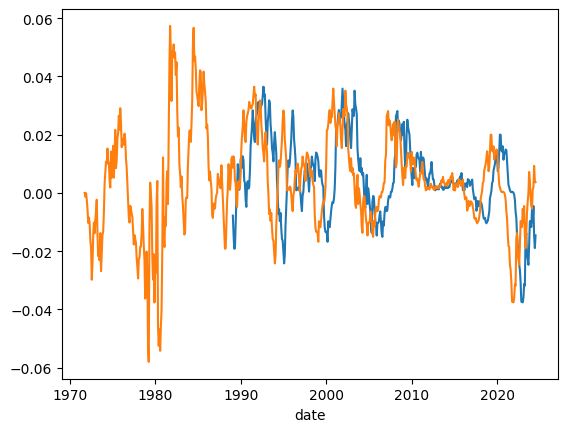

In [10]:
sns.lineplot(y=y_forecast, x=kr_yields.index)
sns.lineplot(y=y, x=kr_yields.index)

# Test in-sample fit

In [5]:
# full-sample R2 for comparison
y = kr_xr['36'].values
model = RandomWalkModel()
model.fit(X, y)
r2_full = sklearn.metrics.r2_score(y, model.predict(X))
r2_full

-0.006271753164280192

<Axes: xlabel='date'>

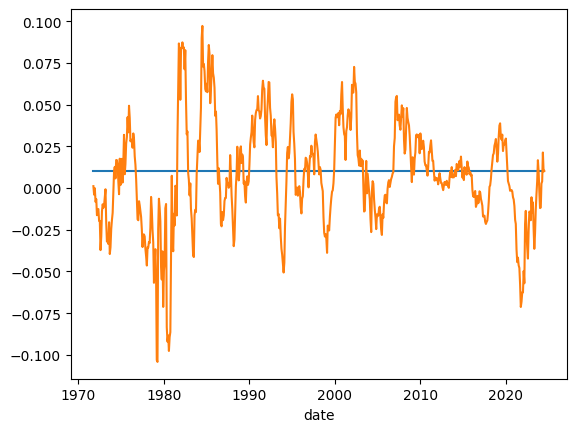

In [6]:
sns.lineplot(y=model.predict(X), x=kr_yields.index)
sns.lineplot(y=y, x=kr_yields.index)